# 📝 Insult Detection with Word2Vec Embeddings

In this notebook, we will build a binary classification pipeline to detect insults in comments using Word2Vec embeddings. We'll apply:
- Logistic Regression
- Random Forest
- XGBoost

## 🚀 Goal
Detect whether a comment contains an insult (1) or not (0).


## 📦 Step 1: Install & Load Packages

In [ ]:
!pip install gensim kagglehub

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

import kagglehub


## 📥 Step 2: Load and Inspect the Dataset


In [7]:
# Dataset: Jigsaw Toxic Comment Classification (we'll use the insult label) from kaggle
df_insult = pd.read_csv("/content/train.csv")

## 🧹 Step 3: Preprocessing for Word2Vec



In [8]:
# We'll use Gensim's `simple_preprocess` to tokenize and clean the text.
df_insult['tokens'] = df_insult['comment_text'].apply(lambda x: simple_preprocess(x, deacc=True))
# deacc=True removes accent marks and punctuations.

## 🧠 Step 4: Train Word2Vec Embedding

In [11]:
# We'll train Word2Vec embeddings on the entire corpus.
# Set parameters
w2v_model = Word2Vec(
    sentences=df_insult['tokens'],
    vector_size=100,   # size of the word vectors
    window=5,          # context window size
    min_count=2,       # ignore words with total frequency lower than this
    workers=4,         # number of threads
    sg=1               # skip-gram model (sg=1), CBOW (sg=0)
)


## 🧬 Step 5: Vectorize Comments using Word2Vec


In [12]:
# Convert each comment to the average of its word vectors
def get_average_vector(tokens, model, vector_size):
    # Collect vectors for words in the model
    valid_vectors = [model.wv[word] for word in tokens if word in model.wv]

    if not valid_vectors:
        # Return zero vector if no known words
        return np.zeros(vector_size)

    # Return average
    return np.mean(valid_vectors, axis=0)

In [14]:
# Convert to final feature and label arrays
# Vector size of your Word2Vec embeddings
vector_size = w2v_model.vector_size

# Convert each comment to an averaged vector
X = np.array([
    get_average_vector(tokens, w2v_model, vector_size)
    for tokens in df_insult['tokens']
])
y = df_insult['toxic'].values



In [15]:
# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y   # keep class balance
)
print("Training set:", X_train.shape, y_train.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (127656, 100) (127656,)
Testing set: (31915, 100) (31915,)


## 🤖 Step 6: Train Models

In [16]:
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n🔍 {name} Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



🔍 Logistic Regression Accuracy: 0.9082
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     28856
           1       0.51      0.88      0.65      3059

    accuracy                           0.91     31915
   macro avg       0.75      0.89      0.80     31915
weighted avg       0.94      0.91      0.92     31915



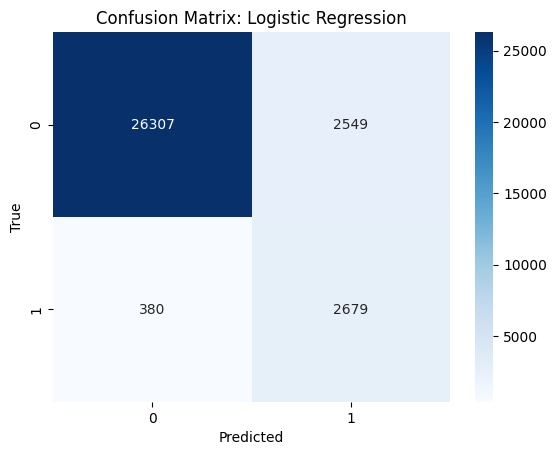

In [17]:
# Logistic Regression
log_reg = LogisticRegression(class_weight='balanced' , max_iter=1000)  # Increase max_iter to ensure convergence
evaluate_model(log_reg, "Logistic Regression")


🔍 Random Forest Accuracy: 0.9497
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     28856
           1       0.91      0.53      0.67      3059

    accuracy                           0.95     31915
   macro avg       0.93      0.76      0.82     31915
weighted avg       0.95      0.95      0.94     31915



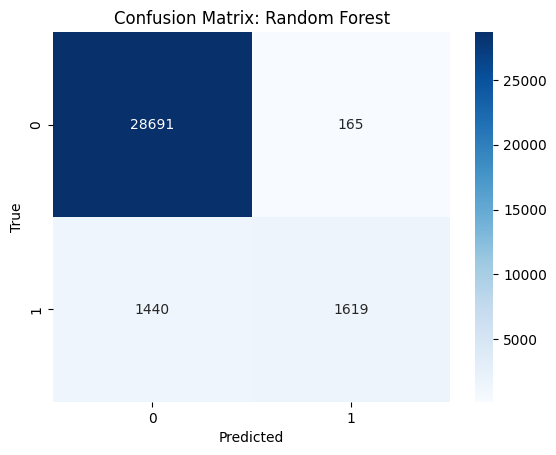

In [18]:
# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,     # number of trees
    max_depth=None,       # let trees grow until all leaves are pure
    random_state=42,
    n_jobs=-1             # use all cores for speed
)

evaluate_model(rf_model, "Random Forest")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:39:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔍 XGBoost Accuracy: 0.9537
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     28856
           1       0.84      0.63      0.72      3059

    accuracy                           0.95     31915
   macro avg       0.90      0.81      0.85     31915
weighted avg       0.95      0.95      0.95     31915



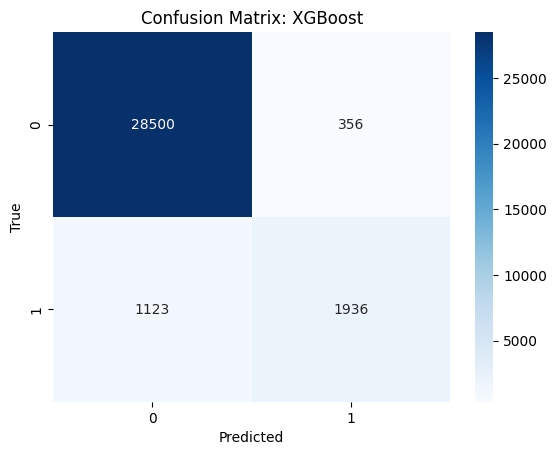

In [19]:
# XGBoost
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

evaluate_model(xgb_model, "XGBoost")

## 📌 Summary

- I learned how to use Word2Vec embeddings for **insult detection**
- Built a custom vectorizer by averaging word vectors
- Trained Logistic Regression, Random Forest, and XGBoost on the resulting features
